# Sentiment analysis using BERT

### Based on course ["Нейронные сети и обработка текста"](https://stepik.org/course/54098/)

If you are going to read this notebook, I recommend you to open it in [google colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and start reading from [the beginning of the analysis](#scrollTo=guw6ZNtaswKc), using the attached hyperlinks on functions and classes if you need to.

## Required libraries, functions and classes:

In [1]:
!pip3 install transformers --quiet
!pip3 install pytorch-nlp --quiet
!pip3 install livelossplot --quiet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from torchnlp.datasets import imdb_dataset

from transformers import BertForSequenceClassification, BertTokenizer, AdamW

from tqdm.notebook import tqdm

from livelossplot import PlotLosses

from copy import deepcopy

import datetime

from traceback import format_exc

In [3]:
def init_random_seed(value=0):
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [4]:
def divisors(n):
    i = 1
    divisors = []
    while i <= n**0.5:
        if (n % i == 0) : 
            if (n / i == i):
                divisors.append(i)
            else:
                divisors.extend([i, n // i])
        i += 1
    return sorted(divisors)

In [5]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [6]:
class BertDataset(Dataset):
    def __init__(self, tokenizer, *data, max_len=None, no_label=False):
        self.no_label = no_label
        if self.no_label:
            self.texts = data
        else:
            self.texts, self.labels = data
        self.tokenizer = tokenizer
        self.max_len = max_len if max_len is not None else max(map(len, self.texts))
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
    
        encoding = tokenizer.encode_plus(
                    text,
                    max_length=self.max_len,
                    add_special_tokens=True,
                    return_token_type_ids=True,
                    return_attention_mask=True,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                    )
        
        if self.no_label:
            return (encoding['input_ids'].squeeze(), encoding['token_type_ids'].squeeze(), encoding['attention_mask'].squeeze())
        
        label = 1 if self.labels[item] == "pos" else 0
        return (encoding['input_ids'].squeeze(), encoding['token_type_ids'].squeeze(), encoding['attention_mask'].squeeze()), torch.tensor(label)

In [7]:
def evaluate(model, dataloader, device, return_score=False, show_bar=False):

    model.eval()
    mean_loss = 0

    if return_score:
        full_true_labels, full_pred_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(dataloader) if show_bar else dataloader:
            batch_x = copy_data_to_device(batch_x, device)
            labels = copy_data_to_device(batch_y, device)
            input_ids, token_type_ids, attention_mask = batch_x
            
            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            if return_score:
                    pred_batch_logits = outputs.logits
                    pred_batch_logits = pred_batch_logits.detach().cpu().numpy()
                    true_batch_labels = labels.to('cpu').numpy()
                    full_pred_labels.extend(np.argmax(pred_batch_logits, axis=1))
                    full_true_labels.extend(true_batch_labels)
         
            mean_loss += float(loss)

        mean_loss /= len(dataloader)
        
        if return_score:
            return mean_loss, accuracy_score(full_true_labels, full_pred_labels)
            
    return mean_loss

In [8]:
def train_eval_loop(model, train_dataset, val_dataset, lr=1e-3, epoch_n=100, batch_size_train=32,
                    batch_size_val=32, accumulation_steps=None, device=None, early_stopping_patience=10, weight_decay=0, data_loader_ctor=DataLoader,
                    optimizer_ctor=None, optimizer_parameters=None, lr_scheduler_ctor=None, dataloader_workers_n=0, draw_loss=False, 
                    show_bar=False, show_lr=False, verbose_freq=1, draw_batch_loss=False, draw_accumulated_batch_loss=False):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        if optimizer_parameters is None:
            optimizer = optimizer_ctor(model.parameters(), lr=lr)
        else:
            optimizer = optimizer_ctor(optimizer_parameters)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    if draw_loss:
        liveplot = PlotLosses()
    if draw_batch_loss:
        liveplot_batch = PlotLosses(step_names=f"batch (of size {batch_size_train})\n{len(train_dataset) // batch_size_train} batches total")
    if draw_accumulated_batch_loss:
        assert accumulation_steps is not None
        liveplot_accumulated_batch = PlotLosses(step_names=f"accumulated batch (contains {accumulation_steps} batches of size {batch_size_train})\n{len(train_dataset) // batch_size_train // accumulation_steps} accumulated batches total")
        mean_accumulated_batch_loss = 0

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size_val, num_workers=dataloader_workers_n)

    best_val_loss = float("inf")
    best_epoch_i = 0
    best_model = deepcopy(model)
    
    for epoch_i in range(epoch_n):
        try:
            if not draw_loss:
                epoch_start = datetime.datetime.now()

            model.train()
            mean_train_loss = 0

            for i, (batch_x, batch_y) in enumerate(tqdm(train_dataloader)) if show_bar else enumerate(train_dataloader):
                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
                input_ids, token_type_ids, attention_mask = batch_x

                loss = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=batch_y).loss

                if accumulation_steps is not None:
                    loss /= accumulation_steps

                loss.backward()

                if draw_batch_loss:
                    liveplot_batch.update({'train loss': loss})
                    liveplot_batch.draw()

                if accumulation_steps is None:
                    optimizer.step()
                    model.zero_grad()
                else:
                    if draw_accumulated_batch_loss:
                        mean_accumulated_batch_loss += float(loss)
                    if (i + 1) % accumulation_steps == 0:
                        optimizer.step()
                        model.zero_grad()
                        if draw_accumulated_batch_loss:
                            liveplot_accumulated_batch.update({'train loss': mean_accumulated_batch_loss})
                            liveplot_accumulated_batch.draw()
                            mean_accumulated_batch_loss = 0


                mean_train_loss += float(loss)

            mean_train_loss /= len(train_dataloader)

            mean_val_loss = evaluate(model, val_dataloader, device=device, show_bar=show_bar)
            
            if not (draw_loss or draw_batch_loss or draw_accumulated_batch_loss) and epoch_i % verbose_freq == 0:
                print(f"Epoch {epoch_i}")
                print('{} iterations for training and {} for validation, {:0.2f} sec'.format(len(train_dataloader), len(val_dataloader),
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
                print('Average value of the train loss function:', mean_train_loss)
                print('Average value of the validation loss function:', mean_val_loss)

            if draw_loss:
                liveplot.update({'mean loss': mean_train_loss, "val_mean loss": mean_val_loss})
                liveplot.draw()

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = deepcopy(model)
                if (not draw_loss) and epoch_i % verbose_freq == 0:
                    print('New best model!')
            elif epoch_i - best_epoch_i == early_stopping_patience:
                print('The model has not improved over the last {} epochs, stop training'.format(
                    early_stopping_patience))
                break
  
            if lr_scheduler is not None:
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(mean_val_loss)
                elif isinstance(lr_scheduler, torch.optim.lr_scheduler.StepLR):
                    lr_scheduler.step()
                    if show_lr:
                        print(optimizer.param_groups[0]['lr'])
                else:
                    lr_scheduler.step()
            if not (draw_loss or draw_batch_loss or draw_accumulated_batch_loss) and epoch_i % verbose_freq == 0:
                print()
        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, format_exc()))
            break

    return best_val_loss, best_model

## Loading [data](https://pytorchnlp.readthedocs.io/en/latest/source/torchnlp.datasets.html#torchnlp.datasets.imdb_dataset) and making train, validation and test [datasets](#scrollTo=Oc0ySmT0RsWN&line=1&uniqifier=1) for BERT:


In [9]:
train, test = imdb_dataset(train=True, test=True)
train_texts, train_labels = [t['text'] for t in train], [t['sentiment'] for t in train]
test_texts, test_labels = [t['text'] for t in test], [t['sentiment'] for t in test]

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True, do_basic_tokenize=True)

In [11]:
MAX_LEN = 512
full_train_dataset = BertDataset(tokenizer, train_texts, train_labels, max_len=MAX_LEN)
test_dataset = BertDataset(tokenizer, test_texts, test_labels, max_len=MAX_LEN)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [12]:
print(f"train set length: {len(train_dataset)}\n  \
val set length: {len(val_dataset)}\n \
test set length: {len(test_dataset)}")

train set length: 20000
  val set length: 5000
 test set length: 25000


In [13]:
print(f"divisors of train dataset size ({len(train_dataset)}) are {divisors(len(train_dataset))}")
print(f"divisors of val dataset size ({len(val_dataset)}) are {divisors(len(val_dataset))}")
print(f"divisors of test dataset size ({len(test_dataset)}) are {divisors(len(test_dataset))}")

batch_size_train = 5
batch_size_val = 100
batch_size_test = 100

divisors of train dataset size (20000) are [1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 80, 100, 125, 160, 200, 250, 400, 500, 625, 800, 1000, 1250, 2000, 2500, 4000, 5000, 10000, 20000]
divisors of val dataset size (5000) are [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 625, 1000, 1250, 2500, 5000]
divisors of test dataset size (25000) are [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 625, 1000, 1250, 2500, 3125, 5000, 6250, 12500, 25000]


## Loading [BERT for sequence classification](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertForSequenceClassification) and fine-tuning:

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [15]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters() if p.requires_grad and not any(nd in n for nd in no_decay)],
     "weight_decay": 0.01,
     "lr": 2e-5},
    {"params": [p for n, p in model.named_parameters() if p.requires_grad and any(nd in n for nd in no_decay)],
     "weight_decay": 0.0,
     "lr": 2e-5}
]

device = "cuda" if torch.cuda.is_available() else "cpu"

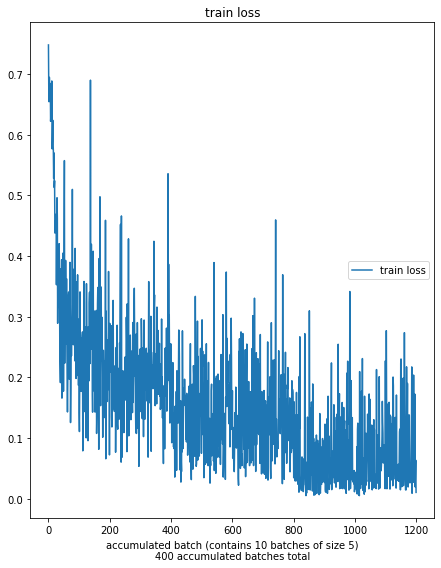

train loss
	train loss       	 (min:    0.005, max:    0.748, cur:    0.011)
The model has not improved over the last 1 epochs, stop training
best val loss:0.1796198


In [16]:
best_val_loss, best_model = train_eval_loop(model,
                                            train_dataset,
                                            val_dataset,
                                            epoch_n=5,
                                            batch_size_train=batch_size_train,
                                            batch_size_val=batch_size_val,
                                            accumulation_steps=10,
                                            early_stopping_patience=1,
                                            optimizer_ctor=AdamW,
                                            optimizer_parameters=optimizer_grouped_parameters,
                                            lr_scheduler_ctor=None,
                                            dataloader_workers_n=5,
                                            draw_loss=False,
                                            show_bar=False,
                                            draw_accumulated_batch_loss=True)

print(f"best val loss:{best_val_loss:.7f}")

In [17]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, num_workers=5)

test_loss, test_score = evaluate(best_model, test_dataloader, device=device, return_score=True, show_bar=True)

print(f"Test sample mean loss: {test_loss:.7f}")
print(f"Test sample accuracy: {test_score * 100:.7f}")


Test sample mean loss: 0.1731645
Test sample accuracy: 93.5760000
